# Seasonal ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

## Data visualization

In [2]:
df = pd.read_csv('portland-oregon-average-monthly-.csv', index_col = 0)
df.index.name = None
df.reset_index(inplace = True)
df.drop(df.index[114], inplace = True)

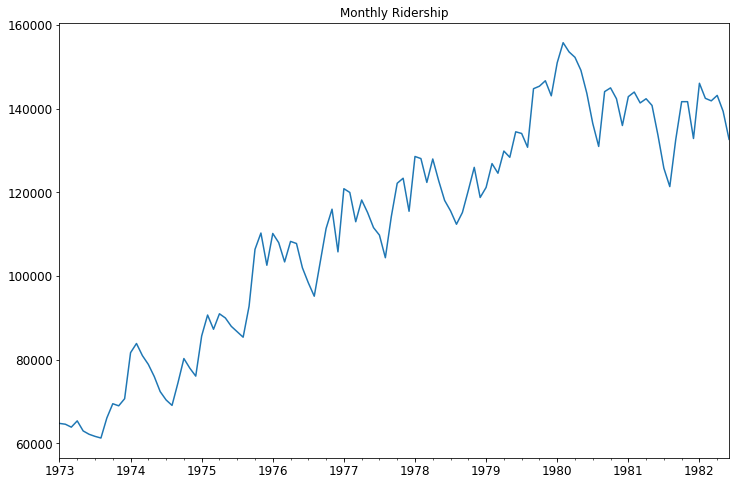

In [3]:
start = datetime.datetime.strptime("1973-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months = x) for x in range(0, 114)]
df['index'] = date_list
df.set_index(['index'], inplace = True)
df.index.name = None
df.columns = ['riders']
df['riders'] = df.riders.apply(lambda x: int(x)*100)
df.riders.plot(figsize = (12, 8), title = "Monthly Ridership", fontsize = 12)

<Figure size 432x288 with 0 Axes>

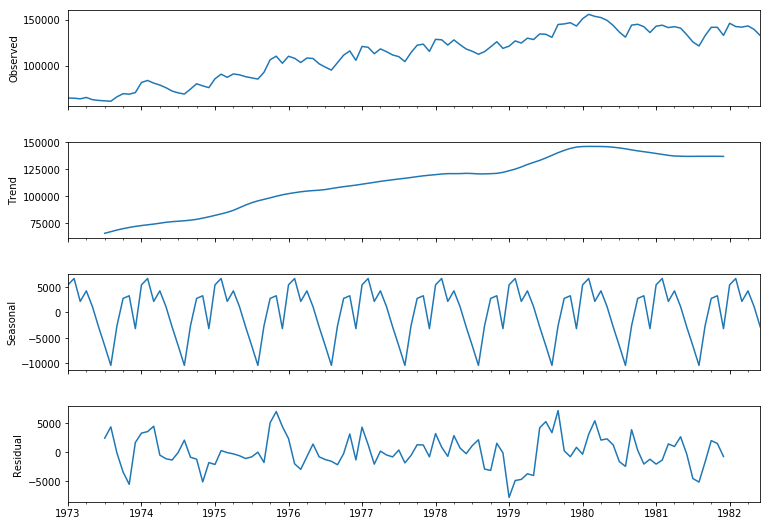

In [4]:
decomposition = seasonal_decompose(df.riders, freq = 12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(12, 8)

In [5]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

## Stationarize the series

In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(timeseries):
    
    # Determing rooling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling statistics
    fig = plt.figure(figsize = (12, 8))
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling std')
    plt.legend(loc = 'best')
    plt.title('Rolling mean and std')
    plt.show()
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test statistic', 'p-value', '#Lags used', '#Observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    print(dfoutput)

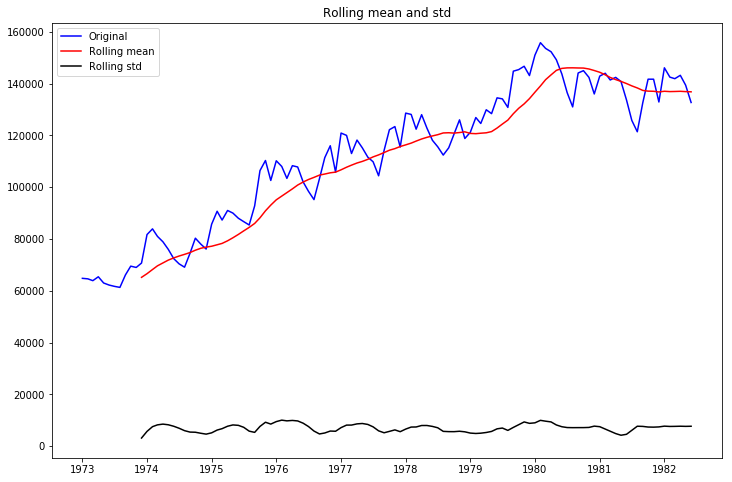

Results of Dickey-Fuller test:
Test statistic           -1.536597
p-value                   0.515336
#Lags used               12.000000
#Observations used      101.000000
Critical value (1%)      -3.496818
Critical value (5%)      -2.890611
Critical value (10%)     -2.582277
dtype: float64


In [7]:
test_stationary(df.riders)

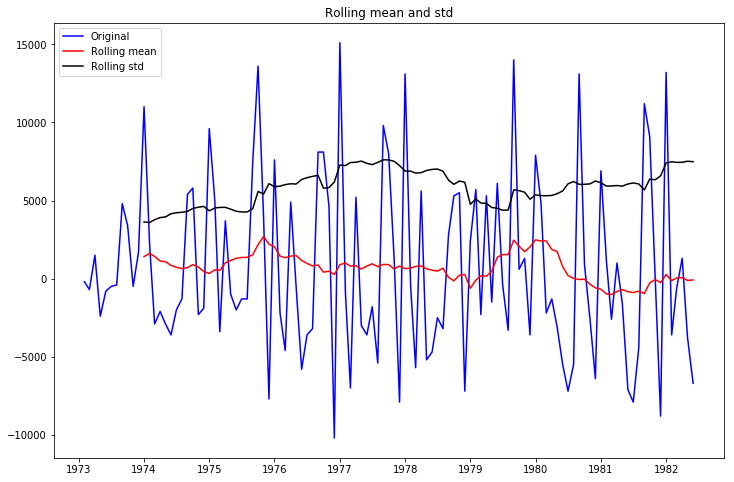

Results of Dickey-Fuller test:
Test statistic           -1.938696
p-value                   0.314082
#Lags used               11.000000
#Observations used      101.000000
Critical value (1%)      -3.496818
Critical value (5%)      -2.890611
Critical value (10%)     -2.582277
dtype: float64


In [8]:
# First-order diff

df['first_difference'] = df.riders - df.riders.shift(1)
test_stationary(df.first_difference.dropna(inplace = False))

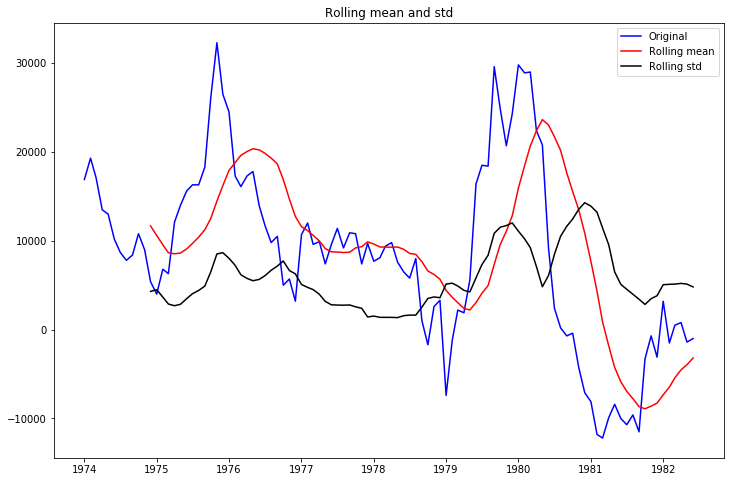

Results of Dickey-Fuller test:
Test statistic          -2.469741
p-value                  0.123011
#Lags used               3.000000
#Observations used      98.000000
Critical value (1%)     -3.498910
Critical value (5%)     -2.891516
Critical value (10%)    -2.582760
dtype: float64


In [9]:
# Seasonal diff

df['seasonal_difference'] = df.riders - df.riders.shift(12)
test_stationary(df.seasonal_difference.dropna(inplace = False))

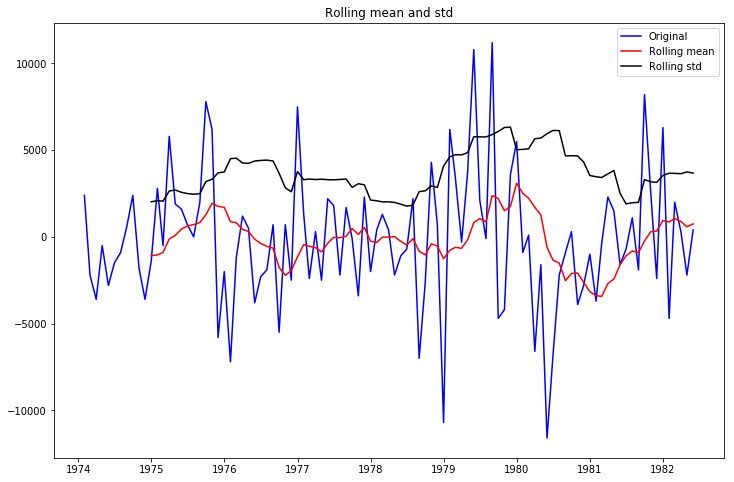

Results of Dickey-Fuller test:
Test statistic         -9.258520e+00
p-value                 1.427874e-15
#Lags used              0.000000e+00
#Observations used      1.000000e+02
Critical value (1%)    -3.497501e+00
Critical value (5%)    -2.890906e+00
Critical value (10%)   -2.582435e+00
dtype: float64


In [10]:
# First-order seasonal diff

df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)
test_stationary(df.seasonal_first_difference.dropna(inplace = False))

C:\Users\maoja\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


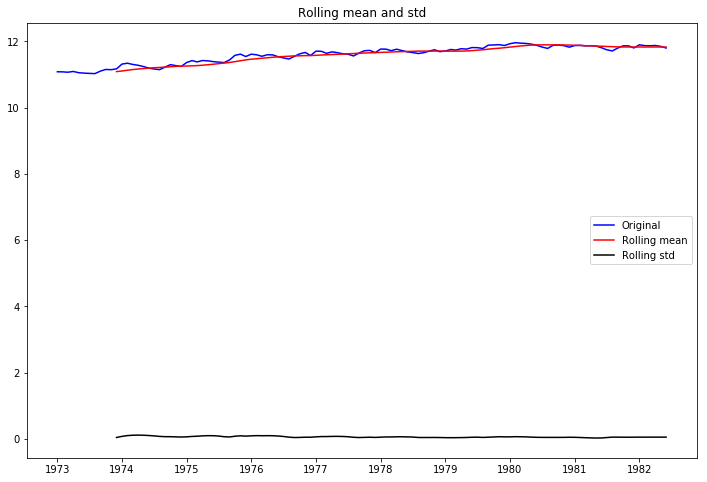

Results of Dickey-Fuller test:
Test statistic           -1.677830
p-value                   0.442570
#Lags used               12.000000
#Observations used      101.000000
Critical value (1%)      -3.496818
Critical value (5%)      -2.890611
Critical value (10%)     -2.582277
dtype: float64


In [11]:
# Log

df.riders_log = df.riders.apply(lambda x: np.log(x))
test_stationary(df.riders_log)

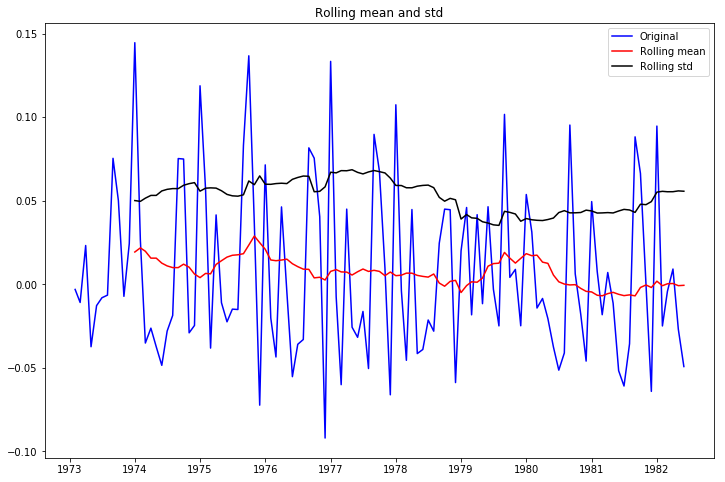

Results of Dickey-Fuller test:
Test statistic           -2.047539
p-value                   0.266126
#Lags used               11.000000
#Observations used      101.000000
Critical value (1%)      -3.496818
Critical value (5%)      -2.890611
Critical value (10%)     -2.582277
dtype: float64


In [12]:
# First-order log

df['log_first_difference'] = df.riders_log - df.riders_log.shift(1)
test_stationary(df.log_first_difference.dropna(inplace = False))

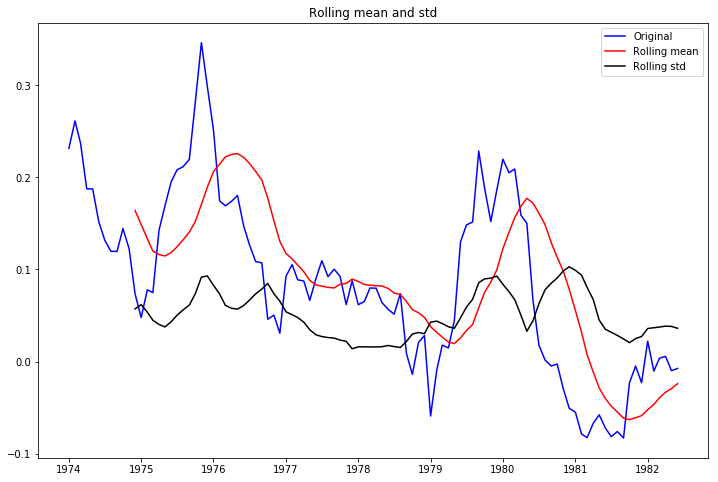

Results of Dickey-Fuller test:
Test statistic           -1.919681
p-value                   0.322860
#Lags used                0.000000
#Observations used      101.000000
Critical value (1%)      -3.496818
Critical value (5%)      -2.890611
Critical value (10%)     -2.582277
dtype: float64


In [13]:
# Seasonal log

df['log_seasonal_difference'] = df.riders_log - df.riders_log.shift(12)
test_stationary(df.log_seasonal_difference.dropna(inplace = False))

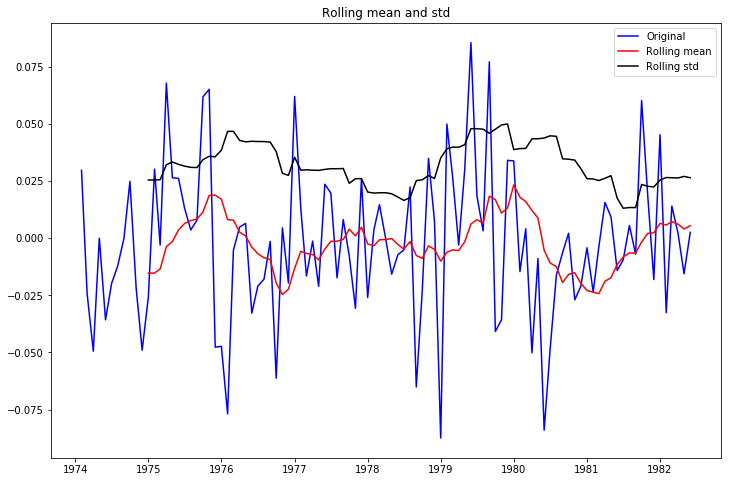

Results of Dickey-Fuller test:
Test statistic         -8.882112e+00
p-value                 1.309452e-14
#Lags used              0.000000e+00
#Observations used      1.000000e+02
Critical value (1%)    -3.497501e+00
Critical value (5%)    -2.890906e+00
Critical value (10%)   -2.582435e+00
dtype: float64


In [14]:
# First-order seasonal log

df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)
test_stationary(df.log_seasonal_first_difference.dropna(inplace = False))

## Plot ACF/PACF to find the optimal parameters

C:\Users\maoja\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


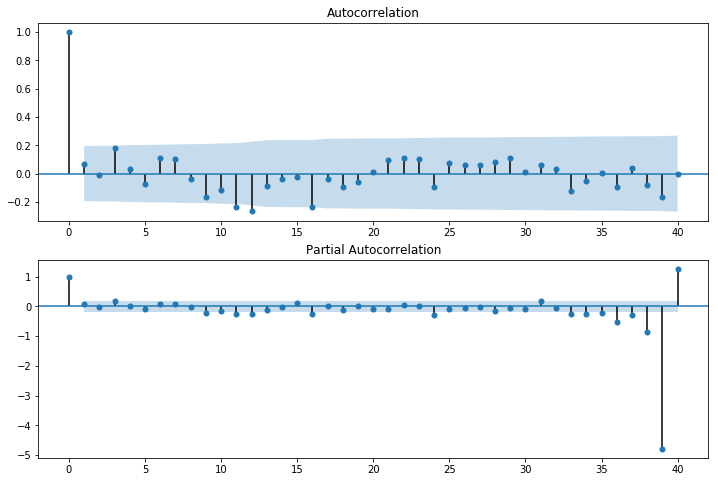

In [15]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:], lags = 40, ax = ax2)

## Build the ARIMA model

In [16]:
mod = sm.tsa.statespace.SARIMAX(df.riders, trend = 'n', order = (0, 1, 0), seasonal_order = (0,1,1,12))
results = mod.fit()
print(results.summary())

C:\Users\maoja\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\maoja\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\maoja\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -976.135
Date:                            Sun, 21 Jul 2019   AIC                           1956.271
Time:                                    13:08:05   BIC                           1961.501
Sample:                                01-01-1973   HQIC                          1958.388
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1377      0.050     -2.757      0.006      -0.236      -0.040
sigma2      1.424e+07   2.62e-10   

In [17]:
mod = sm.tsa.statespace.SARIMAX(df.riders, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

C:\Users\maoja\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -970.257
Date:                            Sun, 21 Jul 2019   AIC                           1946.514
Time:                                    13:08:06   BIC                           1954.359
Sample:                                01-01-1973   HQIC                          1949.690
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5590      0.084      6.679      0.000       0.395       0.723
ma.S.L12      -0.9982      0.117   

## Make predictions

C:\Users\maoja\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


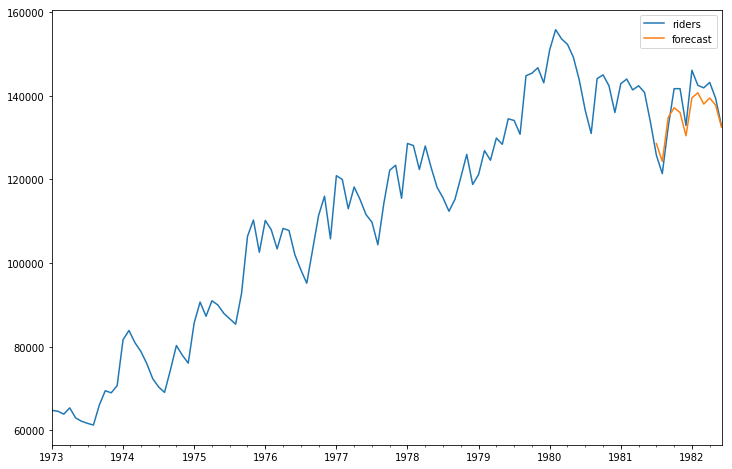

In [18]:
df['forecast'] = results.predict(start = 102, end = 114, dynamic = True)
df[['riders', 'forecast']].plot(figsize = (12, 8))

C:\Users\maoja\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\Users\maoja\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


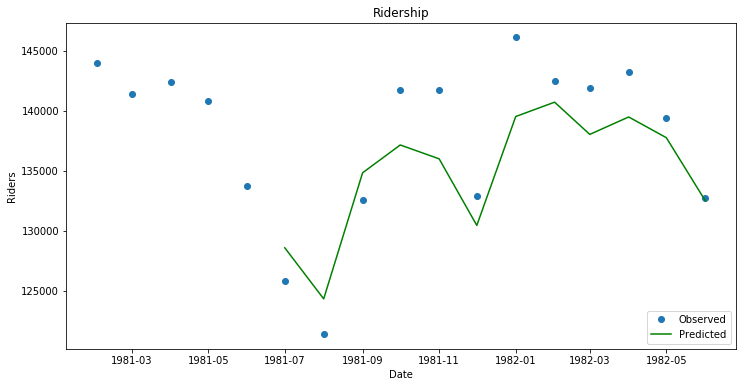

In [19]:
npredict = df.riders['1982'].shape[0]
fig, ax = plt.subplots(figsize = (12, 6))
npre = 12
ax.set(title = "Ridership", xlabel = 'Date', ylabel = "Riders")
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'riders'], 'o', label = 'Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast'], 'g', label = 'Predicted')
legend = ax.legend(loc = 'lower right')
legend.get_frame().set_facecolor('w')

In [20]:
start = datetime.datetime.strptime('1982-07-01', '%Y-%m-%d')
date_list = [start + relativedelta(months = x) for x in range(0, 12)]
future = pd.DataFrame(index = date_list, columns = df.columns)
df = pd.concat([df, future])

C:\Users\maoja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


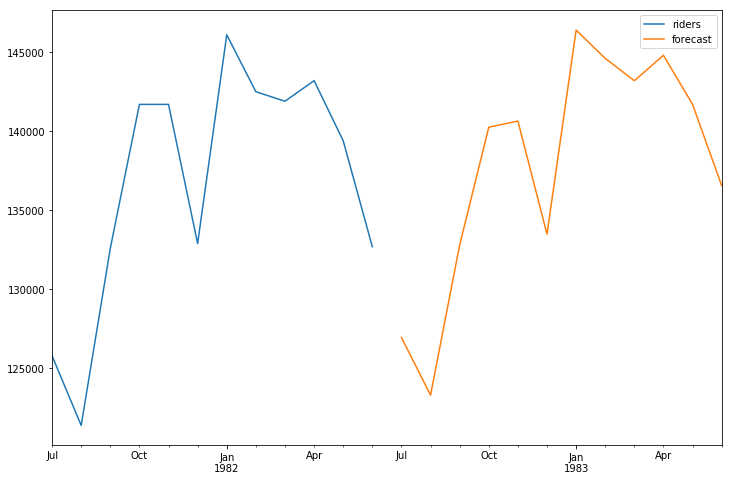

In [21]:
df['forecast'] = results.predict(start = 114, end = 125, dynamic = True)
df[['riders', 'forecast']].ix[-24:].plot(figsize = (12, 8))